<a href="https://colab.research.google.com/github/Manmeet-20/HindiNewsClassifier_BERT/blob/main/Hindi_News_Classifier_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hindi News Classifier using BERT**

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('hindi_news_dataset.csv', encoding='utf-8-sig')

# 2. Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Category'])

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Title'].tolist(),
    df['Label'].tolist(),
    test_size=0.2,
    stratify=df['Label'],
    random_state=42
)

In [ ]:
le.classes_

array(['Crime', 'Education & Career', 'Entertainment', 'Health',
       'India & World', 'Sports'], dtype=object)

In [ ]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


In [ ]:
# PyTorch Dataset
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)


In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(le.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Model Training**

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    report_to=[]
)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.226200,0.761470,0.755581,0.753622,0.769898,0.755581
2,0.597300,0.566599,0.824843,0.822980,0.828411,0.824843
3,0.363900,0.503613,0.848311,0.848948,0.852022,0.848311


TrainOutput(global_step=1311, training_loss=0.7291465078393163, metrics={'train_runtime': 351.4537, 'train_samples_per_second': 59.615, 'train_steps_per_second': 3.73, 'total_flos': 678345217746336.0, 'train_loss': 0.7291465078393163, 'epoch': 3.0})

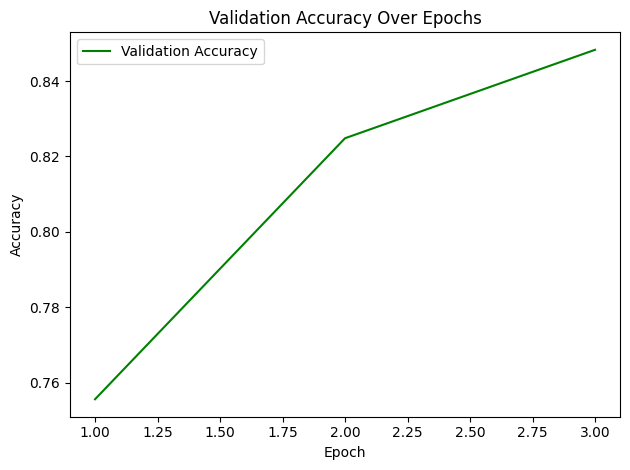

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

eval_accuracy = [x['eval_accuracy'] for x in logs if 'eval_accuracy' in x]

epochs = range(1, len(train_loss) + 1)  # epochs start at 1

plt.plot(epochs, eval_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save_pretrained("./HindiNewsClassifier_bert_model")
tokenizer.save_pretrained("./HindiNewsClassifier_bert_model")


('./HindiNewsClassifier_bert_model/tokenizer_config.json',
 './HindiNewsClassifier_bert_model/special_tokens_map.json',
 './HindiNewsClassifier_bert_model/vocab.txt',
 './HindiNewsClassifier_bert_model/added_tokens.json',
 './HindiNewsClassifier_bert_model/tokenizer.json')

# **Inference**

In [ ]:
model_path = "./HindiNewsClassifier_bert_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

model.eval()
label_list = le.classes_
# ['Crime', 'Education & Career', 'Entertainment', 'Health', 'India & World', 'Sports']
id2label = {i: label for i, label in enumerate(label_list)}

def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return id2label[predicted_class_id]

df = pd.read_csv("test_news_titles.csv")
test_titles = df["Title"].tolist()

for title in test_titles:
    label = predict_label(title)
    print(f"'{title}' => Predicted Label: {label}")

'पत्नि की बेरहमी से हत्या, आरोपी पति गिरफ्तार' => Predicted Label: Crime
'साइबर ठगी का बड़ा मामला आया सामने' => Predicted Label: Crime
'ग्रेजुएट युवाओं के लिए सरकारी बैंक में नौकरी का सुनहरा मौका, 2600 पदों पर निकली वैकेंसी' => Predicted Label: Education & Career
'सीबीएसई बोर्ड परीक्षा की तारीख घोषित' => Predicted Label: Education & Career
'बॉलीवुड एक्टर की नई फिल्म ने तोड़े रिकॉर्ड' => Predicted Label: Entertainment
'वेब सीरीज़ के ट्रेलर ने मचाया धमाल' => Predicted Label: Entertainment
'डेंगू से बचाव के लिए सरकार ने जारी की गाइडलाइन' => Predicted Label: Health
'स्वस्थ रहने के लिए आयुर्वेदिक टिप्स' => Predicted Label: Health
'प्रधानमंत्री की जापान यात्रा पर अंतरराष्ट्रीय समझौते हुए' => Predicted Label: India & World
'चीन सीमा पर भारत की सैन्य तैयारियाँ तेज' => Predicted Label: India & World
'टी20 वर्ल्ड कप के लिए टीम इंडिया का ऐलान' => Predicted Label: Sports
'विराट कोहली ने शतक लगाकर रचा इतिहास' => Predicted Label: Sports


# **Confusion Matrix**

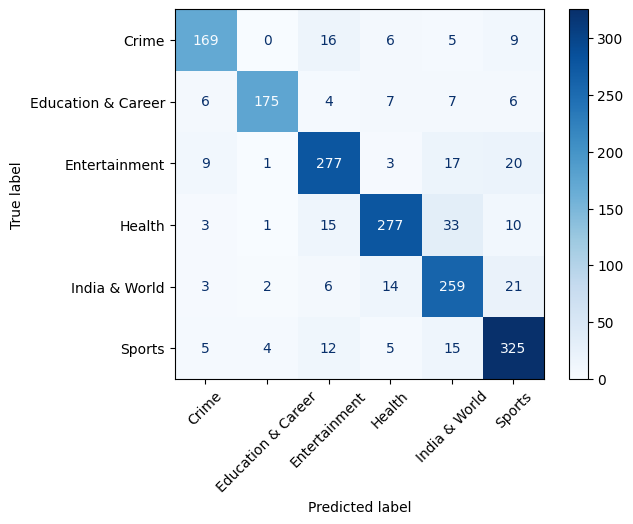

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred_output = trainer.predict(val_dataset)
y_pred = np.argmax(pred_output.predictions, axis=1)
y_true = pred_output.label_ids

labels = le.classes_

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()


In [ ]:
metrics = trainer.evaluate()

data = {
    "Accuracy": metrics.get('eval_accuracy'),
    "F1 Score": metrics.get('eval_f1'),
    "Precision": metrics.get('eval_precision'),
    "Recall": metrics.get('eval_recall')
}

df_metrics = pd.DataFrame(data.items(), columns=["Metric", "Value"])
print(df_metrics)


      Metric     Value
0   Accuracy  0.848311
1   F1 Score  0.848948
2  Precision  0.852022
3     Recall  0.848311
